# import

In [18]:
%load_ext autoreload
%reload_ext autoreload
#autoreload 2：装入所有 %aimport 不包含的模块。
%autoreload 2
#%matplotpy
import numpy as np
from scuteegfe.mne_features_wrapper.feature_wrapper import Feature
import matplotlib.pyplot as plt

# test function content

##  Itakura Distance

In [4]:
from pyts.metrics.dtw import dtw
rng = np.random.RandomState(42)
rng_ = np.random.RandomState(44)
n_epochs, n_channels, n_times = 2, 4,2500
data1= rng.randn(n_channels, n_times)
data2=rng_.randn(n_channels, n_times)
n_channel, n_times = data1.shape
Itakura_distance=np.zeros((n_channel))
for i_channel in range(n_channel):
    Itakura_distance[i_channel]=dtw(x=data1[i_channel,:], y=data2[i_channel,:],
                                    dist='square', method='itakura', 
                                    options={'max_slope': 2.0}, 
                                    precomputed_cost=None, return_cost=False,
                                    return_accumulated=False, return_path=False)
print(Itakura_distance.shape)

(4,)


##  bicoherence

In [ ]:
#test hos
'''
bicoherence input  Multidimensional  vector [n_y,n_d] 
bicoherence input  one-dimensional   vector [n_y,1]  or [1，n_y] 
'''
import os,sys
from scuteegfe.HOSA.conventional.bicoherence import bicoherence
import scipy.io as scio
load_mat = scio.loadmat('qpc.mat')['zmat']
y=load_mat[0:4,:]
y1=np.transpose(load_mat[0:4,:])
y2=load_mat[0,:][np.newaxis,:]
y3=np.transpose(load_mat[1,:][np.newaxis,:])
bicoherence(y, nfft=None, wind=None, nsamp=None, overlap=None)
bicoherence(y1, nfft=None, wind=None, nsamp=None, overlap=None)
bicoherence(y2, nfft=None, wind=None, nsamp=None, overlap=None)
bicoherence(y3, nfft=None, wind=None, nsamp=None, overlap=None)

##  wavelet_entropy unaverage content

In [18]:
import pywt
def imp_extract(section_data,Fs, time_sec,wavelet_name):
    f = np.arange(1, 129, 0.2)
    [wt, f1] = pywt.cwt(section_data, f, wavelet_name, 1 / Fs)  # 'mexh'
    cwt_re = np.sum(abs(wt), axis=1) * 2 / time_sec;  #
    return cwt_re,f1
def band_DE(Pxx, f, Par_ratios=1, band=None):
    """
    Feature extraction of fixed frequency band
    :param Pxx:  frequency band parameter
    :param f:    frequency range
    :param band: selected frequency band
    :return:     固定频带的特征
    """
    fea_num=int(band.shape[0])
    psd = np.empty((fea_num))
    for i in range(fea_num):
        idx = np.where((f >= band[i, 0]) & (f <= band[i, 1]))
        psd[i] = np.sum(np.multiply(Pxx[idx], Pxx[idx]))
        if Par_ratios == 1:
            san_D = np.hstack((psd, psd[2] / psd[1], psd[3] / psd[1]))
        else:
            san_D = psd
    return san_D
rng = np.random.RandomState(42)
n_epochs, n_channels, n_times = 2, 4,2500
data= rng.randn(n_channels, n_times)
sfreq=250
m_times=1
m_Par_ratios=1
m_entropy=True               
wavelet_name= 'gaus1'
Average=False
band=np.array([[2, 3.8], [4, 7], [8, 13], [14, 30], [31, 48]])
time_sec = int(m_times * sfreq)
fea_num = int(band.shape[0] + m_Par_ratios * 2)
n_channel, n_times = data.shape
section_num = int(np.ceil((n_times/ time_sec)))
if Average:
   de = np.empty((int(n_channel),fea_num))
else:
   de = np.empty((int(n_channel),fea_num,section_num))

for channel in range(n_channel):
    # initialization
    section_de = np.empty((fea_num, section_num))
    # for one second calculate cwt
    for section in range(section_num):
        section_data = data[channel, section * time_sec:(section + 1) * time_sec]
        spec, f = imp_extract(section_data=section_data, Fs=sfreq, time_sec=time_sec,wavelet_name=wavelet_name)
        section_de[:, section] = band_DE(spec, f, Par_ratios=m_Par_ratios, band=band)
    if Average:
      de_mean = np.sum(section_de, axis=1);
    else:
      de_mean = section_de; 
    if m_entropy:
        de_mean = np.multiply(de_mean, np.log(de_mean));
    de[channel,:] = de_mean
    print(de.shape)
print(de)
feature = de.reshape(-1)
print(feature)
feashape=feature.reshape((4,7,10))
print(feashape)
print(feature.shape)

(4, 7, 10)
(4, 7, 10)
(4, 7, 10)
(4, 7, 10)
[[[ 5.86436026e+02  9.25562114e+02  4.30583018e+02  9.34658395e+02
    9.96183125e+02  4.56111139e+02  2.82892757e+02  3.18969525e+02
    1.36964145e+02  1.12679455e+03]
  [ 2.47695296e+02  3.03387926e+02  2.11249810e+02  3.31839487e+02
    4.08084982e+02  3.12533833e+02  1.41892121e+02  2.38125381e+02
    1.33547650e+02  2.28881665e+02]
  [ 7.08266867e+01  1.07576245e+02  7.37128149e+01  9.81112973e+01
    1.15995206e+02  1.33383380e+02  6.98686491e+01  1.05458397e+02
    5.97068512e+01  6.33981845e+01]
  [ 5.27696906e+01  7.41641164e+01  6.28198914e+01  5.67764712e+01
    5.50566708e+01  7.76554062e+01  5.67054191e+01  6.55442006e+01
    5.98297736e+01  4.37248337e+01]
  [ 1.31035817e+01  1.24878046e+01  1.07558594e+01  1.15889801e+01
    1.03097580e+01  1.25486637e+01  1.31128660e+01  1.15074316e+01
    1.29877512e+01  1.03944958e+01]
  [-3.67798397e-01 -3.61353471e-01 -3.61257322e-01 -3.67667877e-01
   -3.67874013e-01 -3.44353318e-01 -3.1

# test function

## test EMD

In [ ]:
rng = np.random.RandomState(42)
n_epochs, n_channels, n_times = 2, 2,250
X = rng.randn(n_epochs, n_channels, n_times)
feat1=Feature(X,sfreq=250,selected_funcs={'decorr_time'})
print(feat1.features.shape)
# feat2=Feature(X,sfreq=250,selected_funcs={'pow_freq_bands'})juju
# print(feat2.features.shape)
select_para=dict({'EMD__EMD_times': 1,
                  'EMD__EMD_params': 6})
feat=Feature(X,sfreq=250,selected_funcs={'EMD'},funcs_params=select_para)
print(feat.features.shape)

## test wavelet_entropy  FDA

In [2]:
rng = np.random.RandomState(42)
n_epochs, n_channels, n_times = 2,2,2000
X = rng.randn(n_epochs, n_channels, n_times)
feat=Feature(X,sfreq=250,selected_funcs={'FDA'})#FDA  #wavelet_entropy
print(feat.features.shape)

(2, 2, 8)


##  Itakura Distance

In [3]:
rng = np.random.RandomState(42)
n_epochs, n_channels, n_times = 2,2,2000
rng_ = np.random.RandomState(43)
data1 = rng.randn(n_epochs, n_channels, n_times)
data2=  np.squeeze(rng_.randn(1, n_channels, n_times))
select_para=dict({'Itakura_Distance__baseline_data':data2})
feat=Feature(data1,selected_funcs={'Itakura_Distance'},funcs_params=select_para)

(2, 2000)
(2, 2, 1)


## test wavelet_entropy unaverage function

In [20]:
rng = np.random.RandomState(42)
n_epochs, n_channels, n_times = 2,2,2000
X = rng.randn(n_epochs, n_channels, n_times)
select_para1=dict({'wavelet_entropy__Average': False,'wavelet_entropy__m_entropy': False})
select_para2=dict({'wavelet_entropy__m_entropy': False})
feat1=Feature(X,sfreq=250,selected_funcs={'wavelet_entropy'},funcs_params=select_para1)
feat2=Feature(X,sfreq=250,selected_funcs={'wavelet_entropy'},funcs_params=select_para2)
feat5=feat1.features.reshape((n_epochs, n_channels,7,8))
feat_mean=np.sum(feat5,axis=3)
print("feat1.features",feat1.features.shape,feat1.features)
print("feat2.features",feat2.features.shape,feat2.features)
print("feat_mean",feat_mean.shape,feat_mean)

feat1.features (2, 2, 56) [[[1.22059518e+02 1.78518279e+02 9.46334101e+01 1.79988077e+02
   1.89879705e+02 9.92134080e+01 6.72263283e+01 7.40883578e+01
   6.03991285e+01 7.11401409e+01 5.31658010e+01 7.65068846e+01
   9.05637194e+01 7.28733917e+01 3.87882822e+01 5.85172249e+01
   2.26876283e+01 3.12529579e+01 2.33852597e+01 2.91052202e+01
   3.31357003e+01 3.69521541e+01 2.24549070e+01 3.07753666e+01
   1.81907252e+01 2.34938912e+01 2.07238479e+01 1.92106680e+01
   1.87746164e+01 2.43302620e+01 1.91927028e+01 2.13969569e+01
   6.82347250e+00 6.61147702e+00 6.00189926e+00 6.29771770e+00
   5.84134915e+00 6.63253265e+00 6.82665141e+00 6.26898220e+00
   3.75628406e-01 4.39315379e-01 4.39855306e-01 3.80426158e-01
   3.65882723e-01 5.07073340e-01 5.78909551e-01 5.25919789e-01
   3.01175293e-01 3.30248027e-01 3.89796589e-01 2.51097245e-01
   2.07308363e-01 3.33870311e-01 4.94806723e-01 3.65652283e-01]
  [3.77272049e+01 2.10614622e+02 2.31842121e+02 2.62736423e+02
   1.78305318e+02 1.53162741

# other test

## DFA

[  10   11   12 ... 1998 1999 2000]


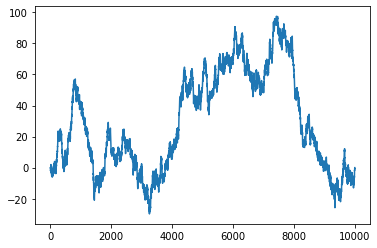

In [37]:
import numpy as np
import fathon
from fathon import fathonUtils as fu

#time series
a = np.random.randn(10000)
#plt.plot(a)
#zero-mean cumulative sum
a = fu.toAggregated(a)

#initialize dfa object
plt.plot(a)
pydfa = fathon.DFA(a)
#compute fluctuation function and Hurst exponent
#wins = fu.linRangeByStep(10, 2000)
wins = np.arange(10, 2001,dtype=np.int64)
print(wins)
#plt.plot(wins)


#compute Hurst exponent in different ranges


(1991,)
(1991,)
(2,) (2,)


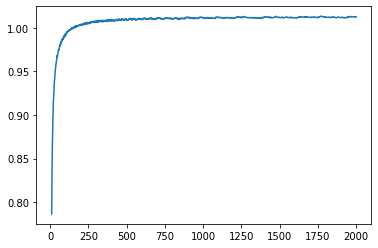

In [35]:
n, F = pydfa.computeFlucVec(wins, revSeg=True, polOrd=3)
print(n.shape)
print(F.shape)
plt.plot(n,F)
H, H_intercept = pydfa.fitFlucVec()


#compute Hurst exponent in different ranges
limits_list = np.array([[15,2000], [200,1000]], dtype=int)
list_H, list_H_intercept = pydfa.multiFitFlucVec(limits_list)
print(list_H.shape, list_H_intercept.shape)
#plt.plot(H,H_intercept)

##  spectrogram_lspopt

In [3]:
import numpy as np
from lspopt.lsp import spectrogram_lspopt
from scipy.signal import chirp, spectrogram
import matplotlib.pyplot as plt
fs = 10000
N = 100000
amp = 2 * np.sqrt(2)
noise_power = 0.001 * fs / 2
time = np.arange(N) / fs
freq = np.linspace(1000, 2000, N)
x = amp * chirp(time, 1000, 2.0, 6000, method='quadratic') + \
    np.random.normal(scale=np.sqrt(noise_power), size=time.shape)
f, t, Sxx = spectrogram_lspopt(x, fs, c_parameter=20.0)
print(f.shape, t.shape, Sxx.shape)


(129,) (446,) (129, 446)


## fft

[0.00000000e+00 1.00080064e-01 2.00160128e-01 ... 1.24799840e+02
 1.24899920e+02 1.25000000e+02]
(1250,)


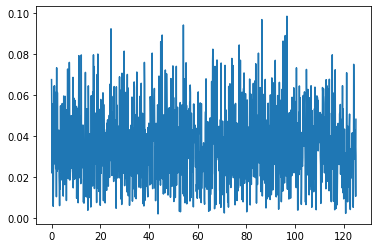

In [19]:
from scipy.fft import  fft,  fftfreq
def get_fft_values(y, N=None, f_s=250):
    '''
    :param y:   array  times
    :param N:   使用的样本数
    :param f_s: 采样频率
    :return:
    f_values    频谱对应的频率
    fft_values  频谱
    '''
    if N is None:
        N=y.shape[0]
    f_values = np.linspace(0.0, f_s/2.0, N//2)
    fft_values_ = fft(y)
    fft_values = 2.0/N * np.abs(fft_values_[0:N//2])
    return f_values, fft_values
rng = np.random.RandomState(42)
n_epochs, n_channels, n_times = 2, 4,2500
data1= rng.randn(n_times)
f,fft=get_fft_values(y=data1,f_s=250)
print(f)
print(fft.shape)
plt.plot(f,fft)

In [21]:

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]
cc=find_nearest([1,11,13,14,9,6,5,8,15],4)
print(cc)

5


In [22]:
np.array([[2, 3.8], [4, 7], [8, 13], [14, 30], [31, 48]]).shape

(5, 2)